In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
df_movie_industry = pd.read_csv("/content/drive/My Drive/Citadel_datathon_2020/movie_industry.csv",encoding = "ISO-8859-1")
df_oscar_award = pd.read_csv('/content/drive/My Drive/Citadel_datathon_2020/the_oscar_award.csv')
df_genome_scores = pd.read_csv('/content/drive/My Drive/Citadel_datathon_2020/movie_lense/genome-scores.csv')
df_genome_tags = pd.read_csv('/content/drive/My Drive/Citadel_datathon_2020/movie_lense/genome-tags.csv')
df_links = pd.read_csv('/content/drive/My Drive/Citadel_datathon_2020/movie_lense/links.csv')
df_movies = pd.read_csv('/content/drive/My Drive/Citadel_datathon_2020/movie_lense/movies.csv')
df_ratings = pd.read_csv('/content/drive/My Drive/Citadel_datathon_2020/movie_lense/ratings.csv')
df_tags = pd.read_csv('/content/drive/My Drive/Citadel_datathon_2020/movie_lense/tags.csv')

In [ ]:
df_movies.genres = df_movies.genres.str.split('|')

list_genre = []
for i in range(len(df_movies)):
  for j in range(len(df_movies['genres'][i])):
    list_genre.append(df_movies['genres'][i][j])

In [ ]:
df_ratings = df_ratings.join(df_movies.set_index('movieId'), on= ['movieId'])

df_ratings['year'] = df_ratings['timestamp'].map(lambda x: datetime.fromtimestamp(x).year)
df_ratings['month'] = df_ratings['timestamp'].map(lambda x: datetime.fromtimestamp(x).month)


#Create One hot ecoded of each movies with genre tagged
mlb = MultiLabelBinarizer(sparse_output=True)

df_ratings = df_ratings.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(df_ratings.pop('genres')),
                index=df_ratings.index,
                columns=mlb.classes_))

#Randon sample the userId since the dataframe is too heavy
userId_index = []
years = np.arange(1996, 2019)
for year in years:
  df_year = df_ratings[df_ratings['year'] == year]
  userIds = list(set(df_year['userId']))
  random_sample = random.sample(userIds, 2000)
  userId_index += (random_sample)

#Create Dataframe with unique userId index with a column of 1 to join the df_ratings
unique_userId = list(set(userId_index))
df_userid = pd.DataFrame(unique_userId, columns= ['userId'])
df_userid['Bool'] = 1

#Retrieve the dataframe with only selected users
df_ratings = df_ratings.join(df_userid.set_index('userId'), on = ['userId'])
df_ratings_sample = df_ratings[df_ratings['Bool'] == 1]
df_ratings_sample = df_ratings_sample.drop('Bool', axis = 1)
df_ratings_sample.index = np.arange(0, len(df_ratings_sample))

#To Skip the above part later
df_ratings_sample.to_csv('sample.csv')

In [4]:
df_ratings_sample = pd.read_csv('/content/drive/My Drive/Citadel_datathon_2020/sample.csv')
df_ratings_sample = df_ratings_sample.drop('Unnamed: 0', axis = 1)
df_ratings_sample.head()

,userId,movieId,rating,timestamp,title,year,month,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,156391,5872,3.5,1204840251,Die Another Day (2002),2008,3,0.0,3.5,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0
1,156036,6296,3.5,1112492083,"Mighty Wind, A (2003)",2005,4,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0
2,245468,2349,4.0,1049892818,Mona Lisa (1986),2003,4,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
3,191117,45447,3.0,1436486035,"Da Vinci Code, The (2006)",2015,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0
4,138483,529,4.0,949346463,Searching for Bobby Fischer (1993),2000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Create X for the elbow method
X = df_ratings_sample

col_to_use = ['userId', 'Action', 'Adventure', 'Animation', 'Children',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',
       'War', 'Western']

X = X.loc[:,col_to_use]
X = X.groupby('userId').mean()
X.to_csv('userId_avg_pref.csv')

In [5]:
userId_avg_pref = pd.read_csv('/content/drive/My Drive/Citadel_datathon_2020/userId_avg_pref.csv')
userId_avg_pref = userId_avg_pref.set_index('userId')
userId_avg_pref.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
userId,,,,,,,,,,,,,,,,,,,
4,2.389706,1.404412,0.161765,0.227941,0.838235,0.867647,0.058824,0.867647,0.647059,0.0,0.235294,0.073529,0.0,0.176471,0.308824,0.875000,1.860294,0.169118,0.139706
14,0.346154,0.653846,1.000000,0.346154,0.884615,1.000000,0.000000,2.538462,0.653846,0.0,0.000000,0.346154,0.0,0.538462,0.884615,0.000000,0.846154,0.653846,0.000000
20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.0,0.000000,0.000000,4.0,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000
24,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,3.000000,3.000000,0.000000,0.000000
35,3.500000,2.916667,0.000000,0.750000,0.833333,0.000000,0.000000,0.666667,0.750000,0.0,0.000000,0.666667,0.0,0.000000,0.000000,2.166667,0.000000,1.333333,0.000000


1 : 2.8085748836573434
2 : 2.62819809038946
3 : 2.5226710910912056
4 : 2.440009978928239
5 : 2.380638376600554
6 : 2.328277991091117
7 : 2.2917795303489976


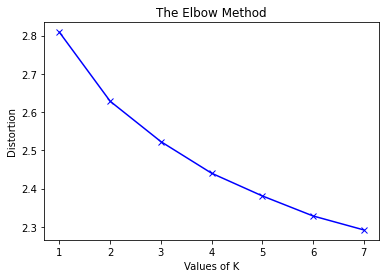

In [6]:
#Perform Elbow Method to decide the number of clusters
X = userId_avg_pref.copy()
X = X.to_numpy()

#Perform the elbow method to see
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

#Perform the elbow method for kmeans to find the optimal number of clusters

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 

K = range(1,8)

for k in K:
  kmeanModel = KMeans(n_clusters = k)
  kmeanModel.fit(X)
  distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                    'euclidean'),axis=1)) / X.shape[0]) 
  inertias.append(kmeanModel.inertia_) 

  mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                'euclidean'),axis=1)) / X.shape[0] 
  mapping2[k] = kmeanModel.inertia_ 

for key,val in mapping1.items(): 
  print(str(key)+' : '+str(val)) 

import matplotlib.pyplot as plt
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method') 
plt.savefig('elbow_method.jpg', bbox_inches='tight', dpi=500) 
plt.show() 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


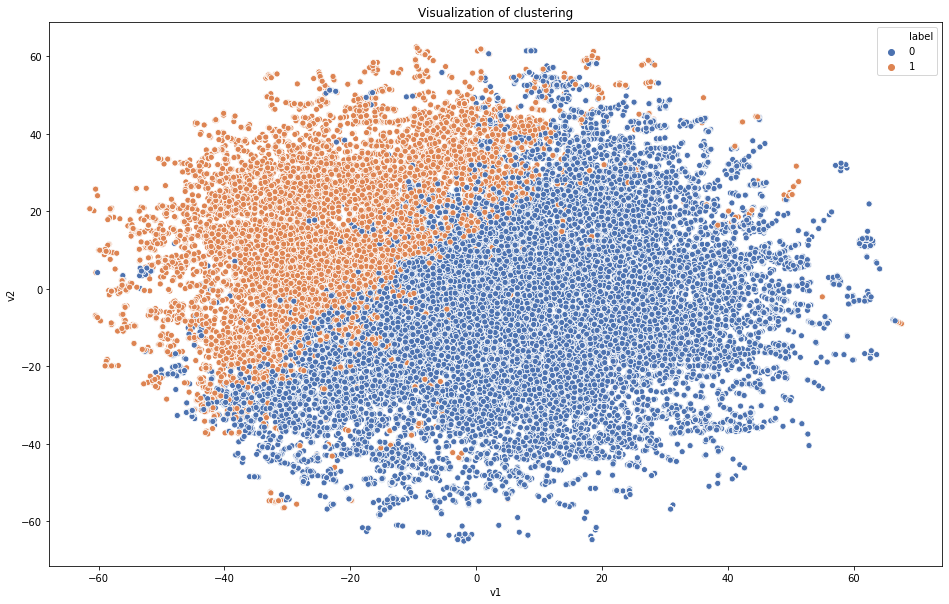

In [7]:
from sklearn.cluster import KMeans


model = KMeans(n_clusters = 2, random_state = 42).fit(X)
yhat = model.labels_

from sklearn.manifold import TSNE

df_clustering_label = TSNE(n_components = 2, random_state = 42).fit_transform(X)

import matplotlib.pyplot as plt
import seaborn as sns
def creat_plotting_data(data,labels):
    """Creates a dataframe from the given data, used for plotting"""
    
    df = pd.DataFrame(data)
    df["label"] = labels
    df.rename({0:"v1", 1:"v2"}, axis=1, inplace=True)
    return df


plotting_data_embedded = creat_plotting_data(df_clustering_label,yhat)
plt.figure(figsize=(16, 10))
ax = sns.scatterplot(x="v1", y="v2", hue = 'label',data=plotting_data_embedded, palette="deep")
ax.set(title = 'Visualization of clustering')
plt.show()

In [8]:
#Show the count of labels
dict_count = {}
dict_count[0] = 0
dict_count[1] = 0
dict_count[2] = 0
for i in range(len(yhat)):
  dict_count[yhat[i]] += 1
dict_count

{0: 28317, 1: 13794, 2: 0}

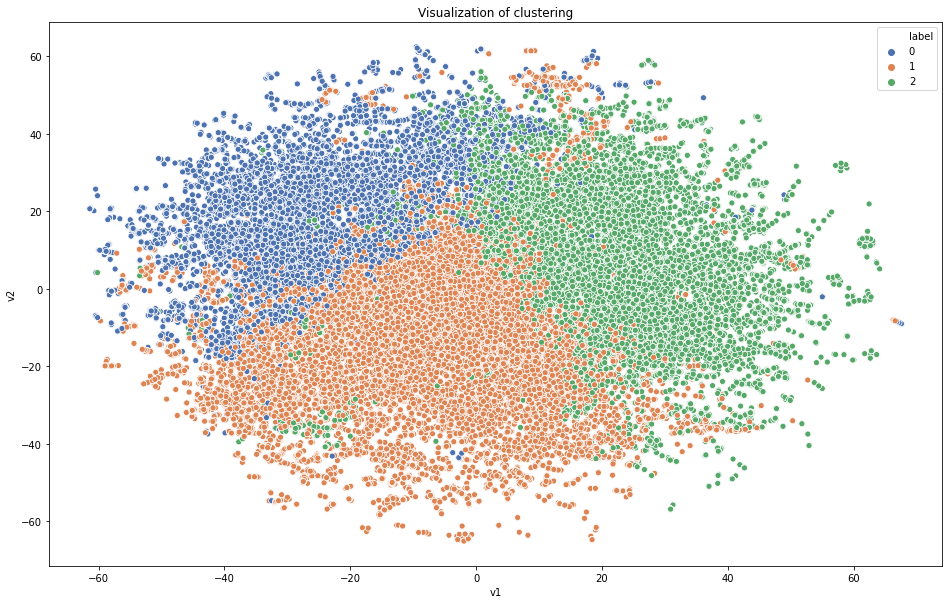

In [9]:
from sklearn.cluster import KMeans


model = KMeans(n_clusters = 3, random_state = 42).fit(X)
yhat = model.labels_

from sklearn.manifold import TSNE

df_clustering_label = TSNE(n_components = 2, random_state = 42).fit_transform(X)


import matplotlib.pyplot as plt
import seaborn as sns
def creat_plotting_data(data,labels):
    """Creates a dataframe from the given data, used for plotting"""
    
    df = pd.DataFrame(data)
    df["label"] = labels
    df.rename({0:"v1", 1:"v2"}, axis=1, inplace=True)
    return df


plotting_data_embedded = creat_plotting_data(df_clustering_label,yhat)
plt.figure(figsize=(16, 10))
ax = sns.scatterplot(x="v1", y="v2", hue = 'label',data=plotting_data_embedded, palette="deep")
ax.set(title = 'Visualization of clustering')
plt.savefig('Clustering.jpg', bbox_inches='tight', dpi=500) 
plt.show()

In [10]:
#Show the count of labels
dict_count = {}
dict_count[0] = 0
dict_count[1] = 0
dict_count[2] = 0
for i in range(len(yhat)):
  dict_count[yhat[i]] += 1
dict_count

{0: 9987, 1: 17636, 2: 14488}

In [ ]:
years = np.arange(1996,2019)
dict_for_graph = {}
for year in years:
  df_by_year = df_ratings_sample[df_ratings_sample['year'] == year].loc[:,col_to_use].groupby('userId').mean()
  X_by_year = df_by_year.to_numpy()
  yhat = model.predict(X_by_year)
  df_clustering_label = TSNE(n_components = 2, random_state = 42).fit_transform(X_by_year)
  plotting_data_embedded = creat_plotting_data(df_clustering_label,yhat)
  dict_for_graph[year] = plotting_data_embedded

In [ ]:
fig, ax = plt.subplots()
for year in years:
        plt.figure(figsize=(16, 10))
        ax = sns.scatterplot(x="v1", y="v2", hue = 'label',data=dict_for_graph[year], palette="deep")
        ax.set(title = 'Visualization of clustering '+ str(year))
        ax.set_xlim(-90,90)
        ax.set_ylim(-90,90)
        plt.savefig(str(year) + '.png', bbox_inches='tight', dpi=500) 
        plt.cla() # needed to remove the plot because savefig doesn't clear it

In [ ]:
df_cluster_center = pd.DataFrame(model.cluster_centers_, columns = df_by_year.columns)
df_cluster_center['label'] = [0,1,2]
df_cluster_center = df_cluster_center.set_index('label')

In [ ]:
count_label = []
for year in years:
  n = len(dict_for_graph[year]['label'])
  label_series = dict_for_graph[year]['label'].value_counts()
  label_list = [label_series[0],label_series[1],label_series[2],label_series[0]/n, label_series[1]/n,label_series[2]/n]
  count_label.append(label_list)

df_count_label = pd.DataFrame(count_label, columns = ['count_0','count_1', 'count_2','freq_0','freq_1','freq_2'])
df_count_label.index = years

In [ ]:
df_count_label.to_csv('count_label.csv')
df_cluster_center.to_csv('cluster_center.csv')

In [ ]:
df_count_label = pd.read_csv('count_label.csv')
df_cluster_center = pd.read_csv('cluster_center.csv')

In [ ]:
df_for_graph = df_count_label.copy()
df_for_graph.columns = ['Year','Label 0','Label 1', 'Label 2' ]
df_for_graph = df_for_graph.set_index('Year')
df_for_graph

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 10))
ax = sns.lineplot(data=df_for_graph)
ax.set(title = 'Visualization of clustering ')
plt.savefig('freq.jpg', bbox_inches='tight', dpi=500) 
plt.show()